In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
def load_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        return img
    except (UnidentifiedImageError, OSError):
        print(f"Error loading image: {img_path}")
        # Return a placeholder image (you can customize this)
        return Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8), 'RGB')



In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=15

In [5]:
# Define the path to your dataset
dataset_path = "/content/drive/MyDrive/plan disease/valid"

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)




Found 5485 files belonging to 12 classes.


In [6]:
class_names = dataset.class_names
class_names

['Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[ 5  4  2  4  2  2 11 10 10 11  1 10 10  1  5  5  7  2  8  8  2 11  4  9
  6 11  3  8  8  9 10  8  4  0 11  7  6 11  5  2  2 11  4  5  7  1  2  7
  0  0  4  0  3 11  5  5  0  2  5  5  4  5  8  0]


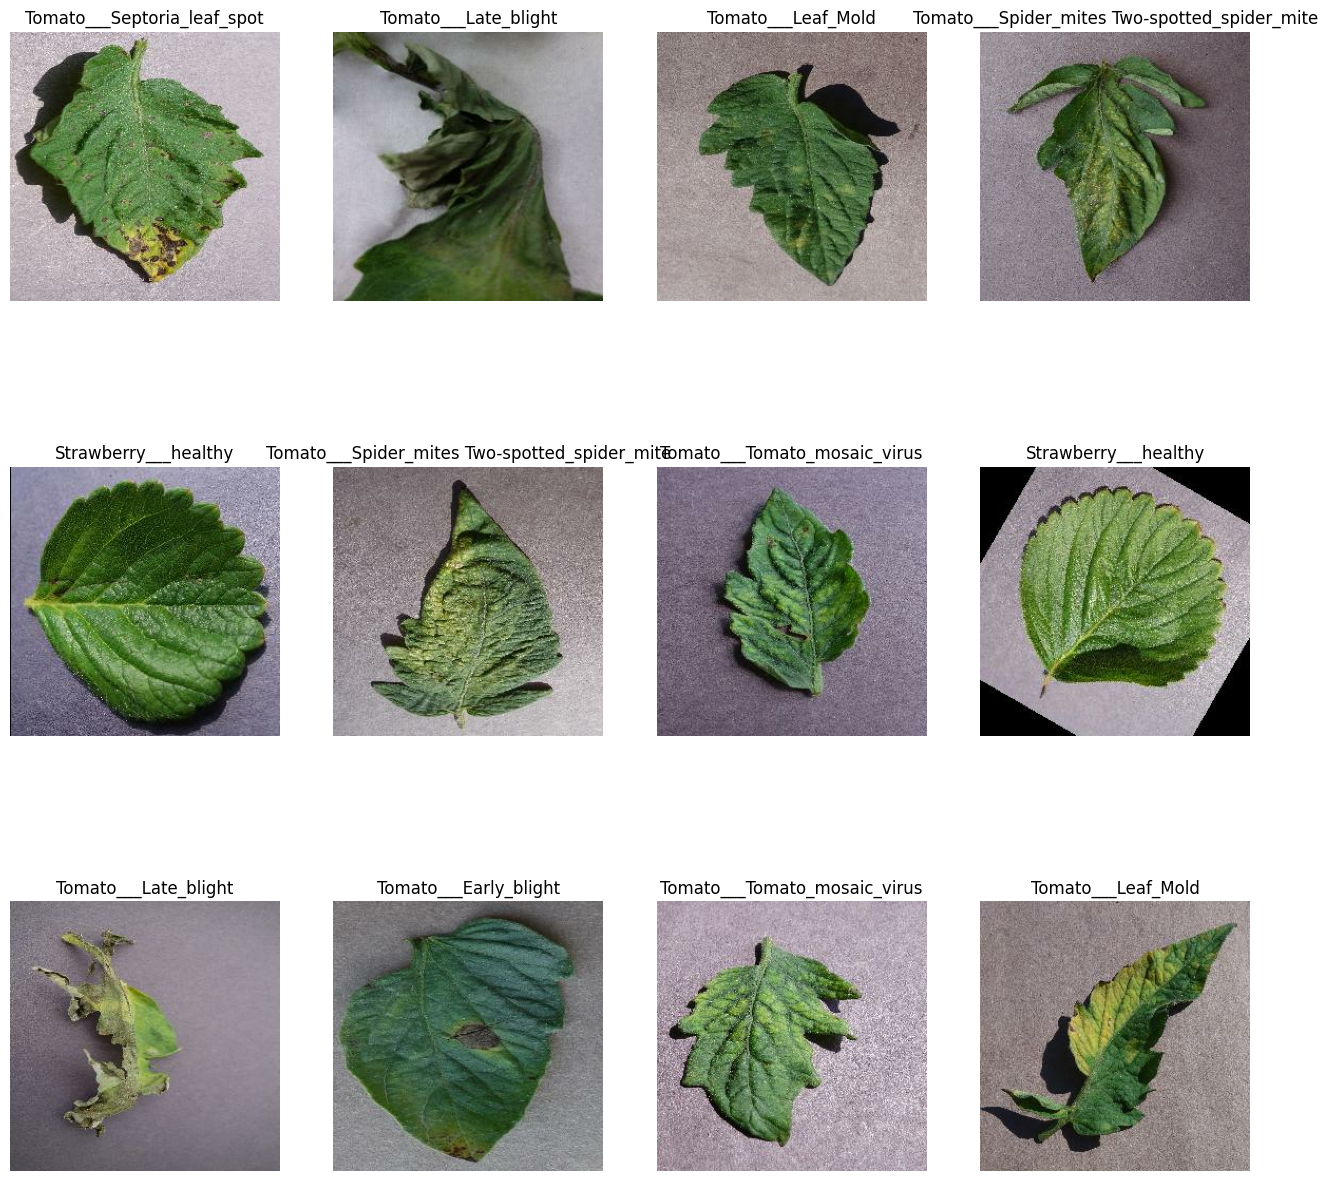

In [8]:
plt.figure(figsize=(16, 16))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

86

In [10]:
train_size = 0.8
len(dataset)*train_size

68.8

In [11]:
train_ds = dataset.take(68)
len(train_ds)

68

In [12]:
test_ds = dataset.skip(68)
len(test_ds)

18

In [13]:
val_size=0.1
len(dataset)*val_size

8.6

In [14]:
val_ds = test_ds.take(8)
len(val_ds)

8

In [15]:
test_ds = test_ds.skip(8)
len(test_ds)

10

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Building the Model

### Creating a Layer for Resizing and Normalization

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 12

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                 

### Compiling the Model

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25
)

Epoch 1/25
68/68 [==============================] - 59s 364ms/step - loss: 2.1292 - accuracy: 0.2379 - val_loss: 1.7247 - val_accuracy: 0.4355
Epoch 2/25
68/68 [==============================] - 8s 113ms/step - loss: 1.4686 - accuracy: 0.4847 - val_loss: 1.0136 - val_accuracy: 0.6465
Epoch 3/25
68/68 [==============================] - 8s 114ms/step - loss: 0.9752 - accuracy: 0.6663 - val_loss: 1.1195 - val_accuracy: 0.6523
Epoch 4/25
68/68 [==============================] - 8s 112ms/step - loss: 0.7217 - accuracy: 0.7570 - val_loss: 0.6266 - val_accuracy: 0.8066
Epoch 5/25
68/68 [==============================] - 8s 113ms/step - loss: 0.6386 - accuracy: 0.7828 - val_loss: 1.0617 - val_accuracy: 0.6719
Epoch 6/25
68/68 [==============================] - 8s 115ms/step - loss: 0.5816 - accuracy: 0.7958 - val_loss: 0.4939 - val_accuracy: 0.8145
Epoch 7/25
68/68 [==============================] - 8s 113ms/step - loss: 0.4932 - accuracy: 0.8304 - val_loss: 0.5368 - val_accuracy: 0.8242
Epoch

### Saving the Model


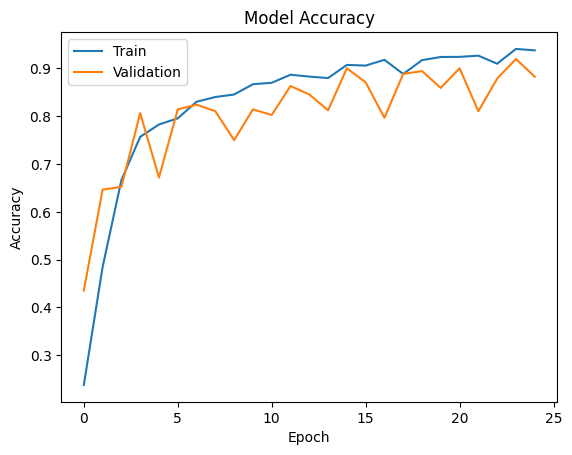

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



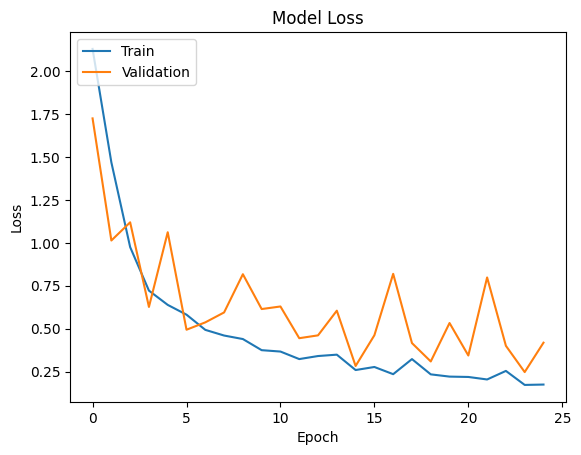

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()